# MLP Hyperparameter Tuning and Training 

In [0]:
# import libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.sql import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, NumericType, DateType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import col, count, mean, stddev, min, max, when, isnan, countDistinct, lit, to_timestamp, to_date, hour, avg, sum, date_sub, current_date, datediff, floor, row_number, date_format, weekofyear, year, round, substring, concat, regexp_replace, lag, last, rank, unix_timestamp, expr, ntile, rand, monotonically_increasing_id
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import gc
from functools import partial

In [0]:
app_name = "basic-training"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

sc = spark.sparkContext

## Load data

In [0]:
train_data = spark.read.parquet("dbfs:/FileStore/tables/train_data3.parquet")
test_data = spark.read.parquet("dbfs:/FileStore/tables/test_data3.parquet")


# switch is_accident to label
train_data = train_data.withColumn("label", (col("is_accident") == 1).cast(IntegerType())).drop("is_accident")
test_data = test_data.withColumn("label", (col("is_accident") == 1).cast(IntegerType())).drop("is_accident")


In [0]:
# drop labelm id columns , and EDA feature 
drop_columns = ['zipcode',"trip_date",  'vehicle_id_encoded', 'driver_id_encoded']

# drop 
drop_columns.extend(["year", "month"])

train_data = train_data.drop(*drop_columns)
test_data = test_data.drop(*drop_columns)

schema = train_data.schema

## Set up pipeline

In [0]:
# find non-numerical columns
numerical_cols = [field.name for field in schema if isinstance(field.dataType, NumericType) and field.name != "label"]
non_numerical_cols = [field.name for field in schema if not isinstance(field.dataType, NumericType)]

# Show results
print("Non-numerical columns:", non_numerical_cols)

Non-numerical columns: []


In [0]:
label_counts=train_data.groupBy('label').count()
counts = {row["label"]: row["count"] for row in label_counts.collect()}

# Assign positive and negative counts
num_positive = counts.get(1, 0)
num_negative = counts.get(0, 0)

print(f"Positive (label=1): {num_positive}")
print(f"Negative (label=0): {num_negative}")

# create POS weight
scale_pos_weight = num_negative / num_positive
print(f"Scale positive weight: {scale_pos_weight}")

train_data = train_data.withColumn(
    "class_weight",
    when(col("label") == 1, scale_pos_weight).otherwise(1.0)
)

Positive (label=1): 260
Negative (label=0): 166819
Scale positive weight: 641.6115384615384


#### Assemble Features 

In [0]:
# Drop zero importance feature columns from GBTClassifier (and all group columns)
zero_importance_features = ['last_has_issues',
 'vehicle_rolling_15trip_num_issues',
 'vehicle_rolling_15trip_issues_distance',
 'vehicle_rolling_15trip_issues_minutes',
 'vehicle_rolling_15trip_issues_events',
 'vehicle_rolling_15trip_issues_given_date',
 'prev_sum_travel_distance',
 'prev_sum_minutes_driving',
 'years_since_min_trip_date',
 'driver_sum_travel_distance_roll15d',
 'driver_sum_minutes_driving_roll15d',
 'crash_roll15d',
 'driver_facing_cam_obstruction_roll15d',
 'drowsiness_roll15d',
 'forward_collision_warning_roll15d',
 'manual_event_roll15d',
 'near_miss_roll15d',
 'ran_a_red_light_roll15d',
 'road_facing_cam_obstruction_roll15d',
 'stop_sign_violation_roll15d',
 'unsafe_lane_change_roll15d',
 'total_events_per_trip_roll15d',
 'high_roll15d',
 'ratio_camera_obstruction_roll15d_per_year',
 'ratio_crash_roll15d_per_year',
 'ratio_driver_facing_cam_obstruction_roll15d_per_year',
 'ratio_drowsiness_roll15d_per_year',
 'ratio_forward_collision_warning_roll15d_per_year',
 'ratio_manual_event_roll15d_per_year',
 'ratio_ran_a_red_light_roll15d_per_year',
 'ratio_road_facing_cam_obstruction_roll15d_per_year',
 'ratio_seat_belt_violation_roll15d_per_year',
 'ratio_tailgating_roll15d_per_year',
 'ratio_unsafe_lane_change_roll15d_per_year',
 'ratio_total_events_per_trip_roll15d_per_year',
 'ratio_trip_ts_roll15d_per_year',
 'ratio_low_roll15d_per_year',
 'ratio_high_roll15d_per_year',
 'prev_review_rate_per_km',
 'prev_review_rate_per_min',
 'prev_review_rate_per_event',
 'group_wi__buckys',
 'group_ga_psi_augusta',
 'group_nc__denver',
 'group_tn__memphis__safety_quip',
 'group_fl__freedom',
 'group_fl__jw_craft',
 'group_ms__american_johnny',
 'group_fl__gainsville_porta_serve',
 'group_pa__port_a_bowl',
 'group_ia__cedar_rapids',
 'group_ga__gci',
 'group_ms__gotta_go',
 'group_pa__malvern',
 'group_tx__forza',
 'group_tn__fusionsite_(clark)',
 'group_san_angelo_tops_septic',
 'group_wi__stranders',
 'group_az__stamback_admin',
 'group_oh__rent__a__john',
 'group_az__stamback_rolloffs_',
 'group_nc__griffin_hook_trucks',
 'group_tn__maxwell_septic',
 'group_ky__lex',
 'group_nc__asc',
 'group_tn__chattanooga_bolles',
 'group_tn__etp_',
 'group_sc__littlejohn',
 'group_tx__acp',
 'group_va__r_r',
 'group_sc__psi_columbia',
 'group_ky__bullitt_sep_service',
 'group_ky__moon_minis',
 'group_ky__moon_leasing',
 'group_nc__greensboro',
 'group_tn__fusionsite_(woodycrest)',
 'group_ky__moon_portables',
 'group_tx__j_bar',
 'group_ar__fay',
 'group_lubbock_hd_',
 'group_az__stamback_septic',
 'group_kermit',
 'group_lubbock',
 'group_wi__cesspool',
 'group_tn__fusionsite_(nashville)',
 'group_tn__mc_septic',
 'group_ny__a__john',
 'group_nc__griffin_waste_pump_trucks',
 'group_oh__c_l_and_safeway',
 'group_ar__little_rock'
 'total_fatalities_prev_3m_avg',
 'total_vehicles_prev_3m_avg']

In [0]:
# Drop zero_importance_features from train_df and test_df
train_data = train_data.drop(*zero_importance_features)
test_data = test_data.drop(*zero_importance_features)

In [0]:
# Function to make sure train/val split is stratified 
def stratified_split(df, label_col="label", train_frac=0.8, seed=42):
    fractions = df.select(label_col).distinct().withColumn(
        "fraction", F.lit(train_frac)
    ).rdd.collectAsMap()
    
    # Sample by class
    train_subset = df.stat.sampleBy(label_col, fractions, seed)
    
    # Get the validation set as the remaining data
    # Using a left anti join to get rows in df that aren't in train_subset
    validation_subset = df.join(
        train_subset, 
        on=df.columns, 
        how="left_anti"
    )
    return train_subset, validation_subset

## Cross-Validation

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import numpy as np
import time

In [0]:
train_subset, validation_subset = stratified_split(train_data)

In [0]:
# Combine the train and validation subsets with a column indicating which is which
from pyspark.sql.functions import lit

# Add a column to indicate training vs validation data
train_with_indicator = train_subset.withColumn("train_val_indicator", lit(0))  # 0 for training
val_with_indicator = validation_subset.withColumn("train_val_indicator", lit(1))  # 1 for validation

# Union the datasets
combined_data = train_with_indicator.union(val_with_indicator)

In [0]:
train_with_indicator = train_subset.withColumn("train_val_indicator", lit(0))  # 0 for training
val_with_indicator = validation_subset.withColumn("train_val_indicator", lit(1))  # 1 for validation

# Union the datasets
combined_data = train_with_indicator.union(val_with_indicator)

feature_cols = [col for col in train_data.columns if col not in ['label', 'class_weight', 'train_val_indicator']]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")

# Add StandardScaler to normalize the features
scaler = StandardScaler(
    inputCol="assembled_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Get the number of features and classes
num_features = len(feature_cols)
num_classes = train_data.select("label").distinct().count()


In [0]:
# Create the evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

In [0]:
###########################################
# VERSION 2: WITH EARLY STOPPING
###########################################

print("\n========== TRAINING MODEL WITH EARLY STOPPING ==========")
start_time = time.time()

# Create the MultilayerPerceptronClassifier WITH early stopping
mlp_early_stopping = MultilayerPerceptronClassifier(
    labelCol="label", 
    featuresCol="features", 
    predictionCol="prediction",
    maxIter=100,
    seed=42,
    # Early stopping parameters
    tol=1e-6,           # Convergence tolerance
    stepSize=0.01,      # Default step size (will be tuned)
)

# Create separate pipeline for each combination
best_accuracy = 0
best_params = None
best_pipeline = None
best_iter_count = 0

print("Testing different configurations with early stopping:")

for layers in [[num_features, 10, num_classes], [num_features, 16, 8, num_classes]]:
    for step_size in [0.001, 0.01, 0.1]:
        print(f"  Testing: layers={layers}, stepSize={step_size}")
        
        # Create MLP with these parameters and early stopping capability
        mlp = MultilayerPerceptronClassifier(
            labelCol="label", 
            featuresCol="features", 
            predictionCol="prediction",
            layers=layers,
            stepSize=step_size,
            maxIter=100,
            tol=1e-6,
            seed=42
        )
        
        # Create pipeline
        pipeline = Pipeline(stages=[assembler, scaler, mlp])
        
        # Custom early stopping implementation
        best_val_accuracy = 0
        patience = 5  # Number of iterations to wait for improvement
        patience_counter = 0
        iter_count = 0
        
        for i in range(1, 21):  # Check validation every 5 epochs, up to 100 iterations
            iter_count = i * 5
            
            # Update the MLP with more iterations
            mlp.setMaxIter(iter_count)
            model = pipeline.fit(train_subset)
            
            # Evaluate on validation set
            val_predictions = model.transform(validation_subset)
            val_accuracy = evaluator.evaluate(val_predictions)
            
            print(f"    Iteration {iter_count}, Validation Accuracy: {val_accuracy:.4f}")
            
            # Check for improvement
            if val_accuracy > best_val_accuracy + 0.001:  # Improvement threshold
                best_val_accuracy = val_accuracy
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Early stopping condition
            if patience_counter >= patience:
                print(f"    Early stopping at iteration {iter_count}")
                break
        
        # Compare with best so far
        if best_val_accuracy > best_accuracy:
            best_accuracy = best_val_accuracy
            best_params = {
                "layers": layers,
                "stepSize": step_size
            }
            best_pipeline = model
            best_iter_count = iter_count



========== TRAINING MODEL WITH EARLY STOPPING ==========
Testing different configurations with early stopping:
  Testing: layers=[48, 10, 2], stepSize=0.001
    Iteration 5, Validation Accuracy: 0.5780
    Iteration 10, Validation Accuracy: 0.6881
    Iteration 15, Validation Accuracy: 0.7136
    Iteration 20, Validation Accuracy: 0.6799
    Iteration 25, Validation Accuracy: 0.6445
    Iteration 30, Validation Accuracy: 0.6392
    Iteration 35, Validation Accuracy: 0.6145
    Iteration 40, Validation Accuracy: 0.6221
    Early stopping at iteration 40
  Testing: layers=[48, 10, 2], stepSize=0.01
    Iteration 5, Validation Accuracy: 0.5780
    Iteration 10, Validation Accuracy: 0.6881
    Iteration 15, Validation Accuracy: 0.7136
    Iteration 20, Validation Accuracy: 0.6799
    Iteration 25, Validation Accuracy: 0.6445
    Iteration 30, Validation Accuracy: 0.6392
    Iteration 35, Validation Accuracy: 0.6145
    Iteration 40, Validation Accuracy: 0.6221
    Early stopping at iterat

In [0]:
# print best param 
print(best_params)

{'layers': [48, 16, 8, 2], 'stepSize': 0.1}


### Calculate Cluster size and Experiment Time

In [0]:
# Use the Java map's size() method directly
num_executors = sc._jsc.sc().getExecutorMemoryStatus().size() - 1  # subtract 1 for the driver

parallelism = sc.defaultParallelism

print(f"Number of executors (excluding driver): {num_executors}")
print(f"Default parallelism: {parallelism}")


# Calculate training time
training_time_early_stopping = time.time() - start_time
print(f"Training time with early stopping: {training_time_early_stopping:.2f} seconds")

# Print best model parameters
print("Best model parameters (with early stopping):")
print(f"Layers: {best_params['layers']}")
print(f"Step Size: {best_params['stepSize']}")
print(f"Iterations needed: {best_iter_count}")


Number of executors (excluding driver): 0
Default parallelism: 4
Training time with early stopping: 1962.85 seconds
Best model parameters (with early stopping):
Layers: [48, 16, 8, 2]
Step Size: 0.1
Iterations needed: 50


### Model Performance on Train Data 

In [0]:

## Evaluate on train data 
train_predictions = best_pipeline.transform(train_data)

# Set up evaluation metrics

# AUC evaluator (area under ROC)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# AUPRC evaluator (area under PR)
auprc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)

# Precision evaluator (weighted precision)
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedPrecision"
)

# Recall evaluator (weighted recall)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedRecall"
)

# F1 evaluator
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="f1"
)

# Evaluate the predictions
auc = auc_evaluator.evaluate(train_predictions)
auprc = auprc_evaluator.evaluate(train_predictions)
precision = precision_evaluator.evaluate(train_predictions)
recall = recall_evaluator.evaluate(train_predictions)
f1 = f1_evaluator.evaluate(train_predictions)

# Print the evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("AUC:")
print(auc)
print("AUPRC:")
print(auprc)


Precision: 0.9980680739326253
Recall: 0.9984977166490103
F1 Score: 0.9978692018687082
AUC:
0.8296078614915179
AUPRC:
0.04913886592399326


In [0]:
metrics = train_predictions.select(
    sum(when(col("prediction") == 1.0, 1).otherwise(0)).alias("predicted_positives"),
    sum(when(col("label") == 1.0, 1).otherwise(0)).alias("actual_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 1.0), 1).otherwise(0)).alias("true_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 0.0), 1).otherwise(0)).alias("false_positives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 0.0), 1).otherwise(0)).alias("true_negatives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 1.0), 1).otherwise(0)).alias("false_negatives")
).collect()[0]

# Extract values from the Row
predicted_positives = metrics.predicted_positives
actual_positives = metrics.actual_positives
actual_negatives = train_predictions.count() - actual_positives
true_positives = metrics.true_positives
false_positives = metrics.false_positives
true_negatives = metrics.true_negatives
false_negatives = metrics.false_negatives

# Calculate TPR, FPR, and PPV
tpr = float(true_positives) / float(actual_positives) if actual_positives > 0 else 0.0
fpr = float(false_positives) / float(actual_negatives) if actual_negatives > 0 else 0.0
ppv = float(true_positives) / float(predicted_positives) if predicted_positives > 0 else 0.0

print(f"True Positives Rate: {tpr}")
print(f"False Positive Rate: {fpr}")
print(f"Positive Predictive Value: {ppv}")

True Positives Rate: 0.06153846153846154
False Positive Rate: 4.1961647054592104e-05
Positive Predictive Value: 0.6956521739130435


In [0]:
def extract_positive_prob(probability_vector):
    return float(probability_vector[1])

extract_positive_prob_udf = udf(extract_positive_prob, DoubleType())

# Use the UDF to create the 'probability_pos' column and convert the Spark DataFrame to Pandas
pandas_df = train_predictions.select(
    col("label").cast("double").alias("label"),
    col("prediction").cast("double").alias("prediction"),
    extract_positive_prob_udf(col("probability")).alias("probability_pos")
).toPandas()


# Get data for calculations
y_true = pandas_df["label"].values
y_pred = pandas_df["prediction"].values
y_prob = pandas_df["probability_pos"].values
    

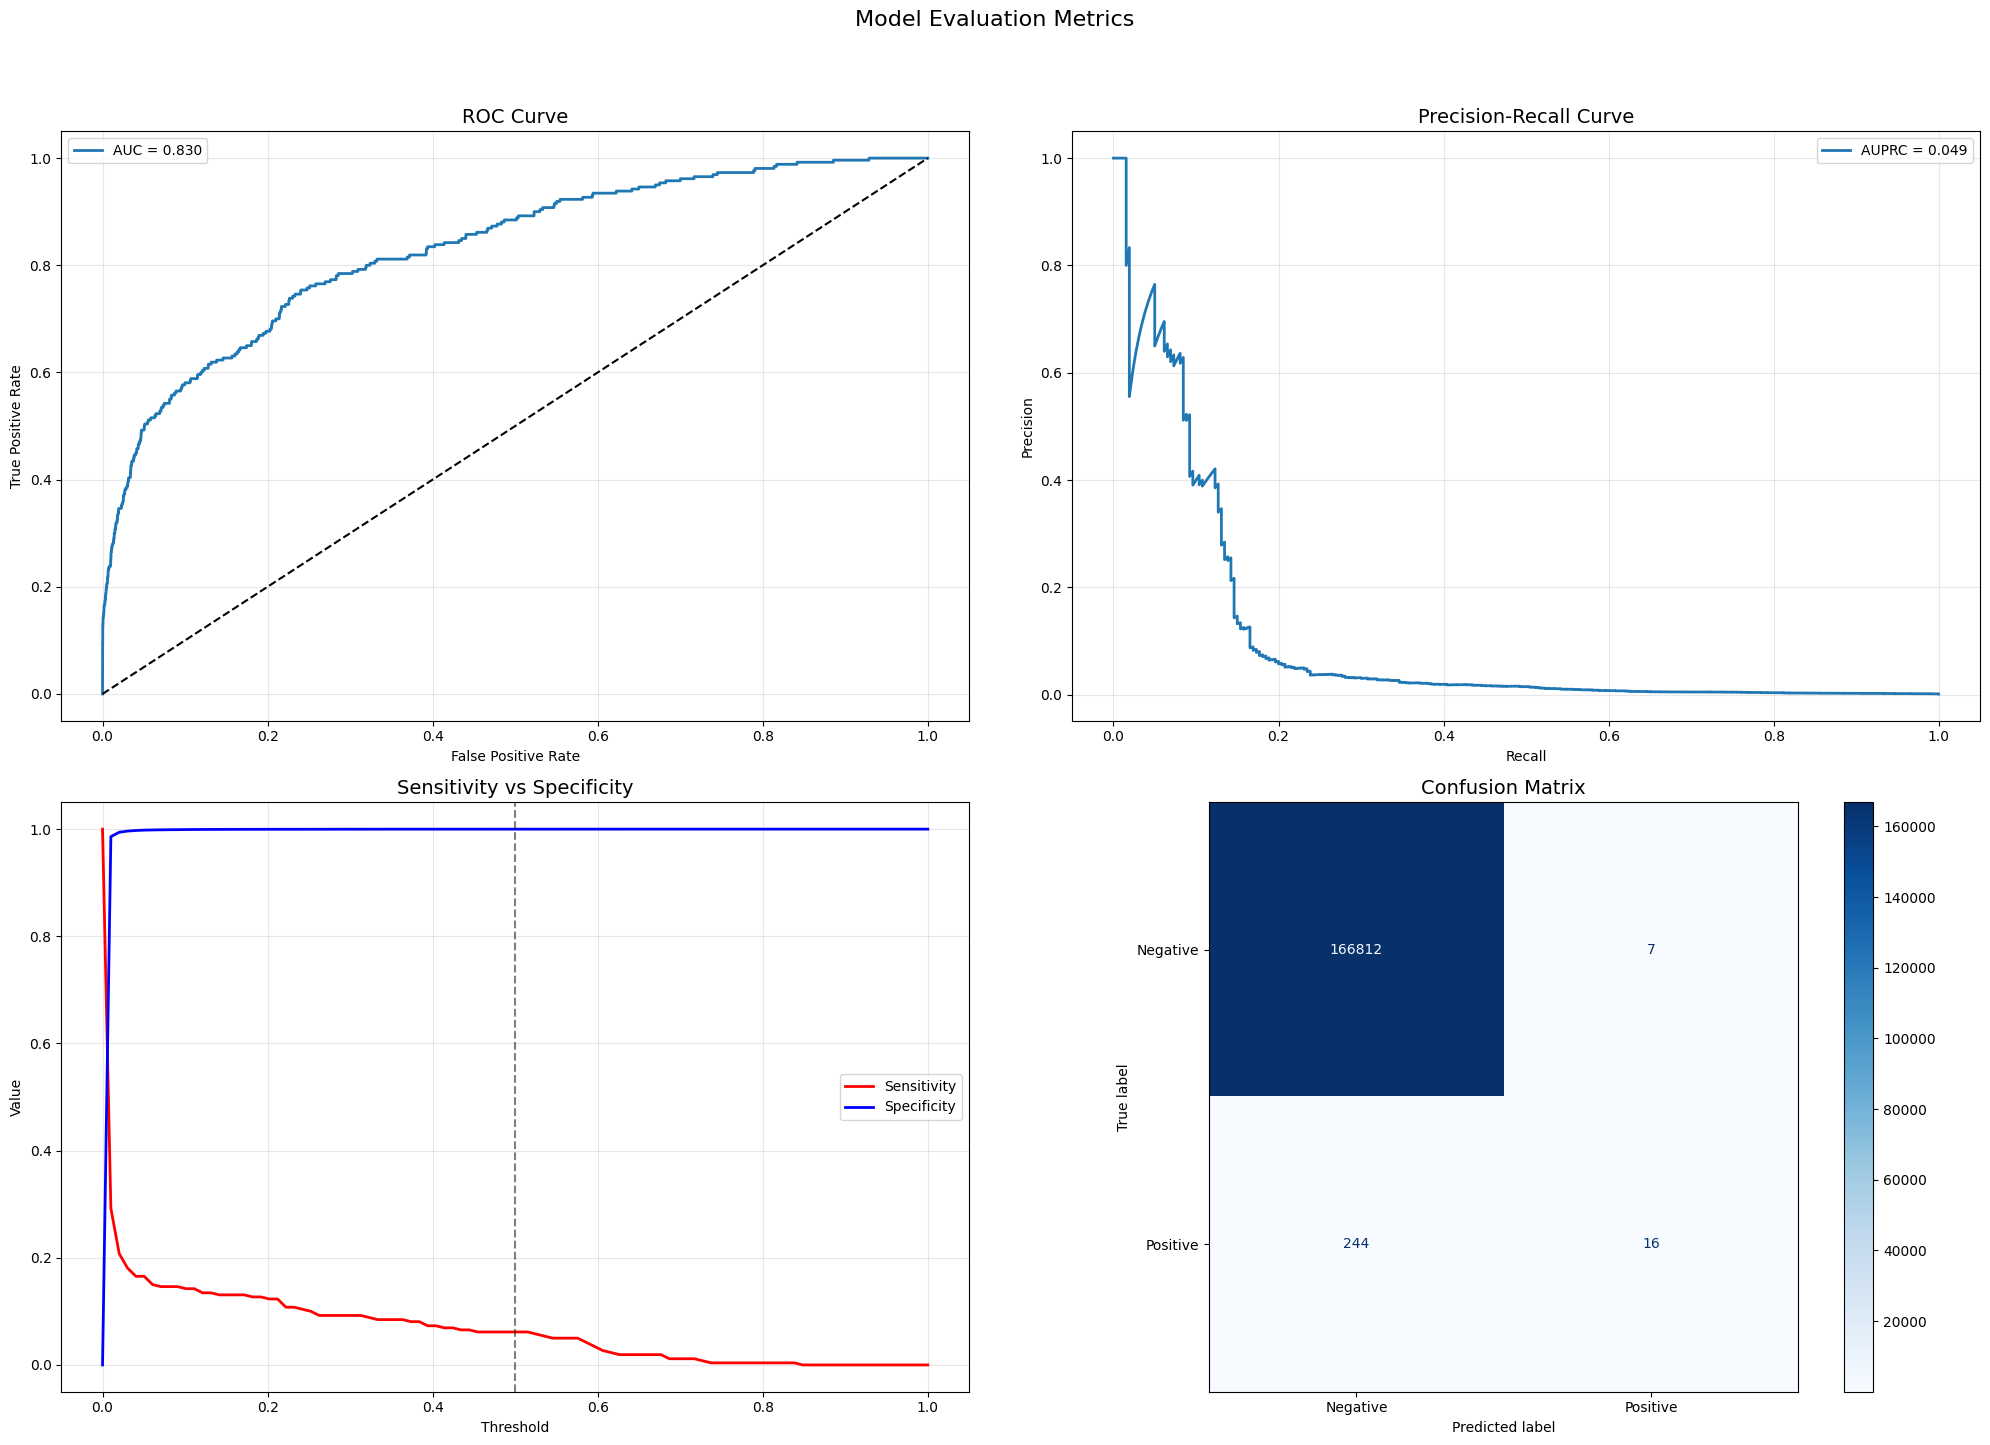

In [0]:
## Plotting against the train data 

threshold = 0.5

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
ax1 = plt.subplot(2, 2, 1)
ax1.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')  # auc should be calculated from your evaluator
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_prob)
ax2 = plt.subplot(2, 2, 2)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'AUPRC = {auprc:.3f}')  # auprc from evaluator
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Sensitivity vs Specificity at different thresholds
thresholds_range = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

for t in thresholds_range:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity.append(sens)
    specificity.append(spec)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(thresholds_range, sensitivity, 'r-', linewidth=2, label='Sensitivity')
ax3.plot(thresholds_range, specificity, 'b-', linewidth=2, label='Specificity')
ax3.axvline(x=threshold, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Value')
ax3.set_title('Sensitivity vs Specificity', fontsize=14)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ax4 = plt.subplot(2, 2, 4)
# ConfusionMatrixDisplay will plot on the provided axis
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(ax=ax4, cmap='Blues', values_format='d')
ax4.set_title('Confusion Matrix', fontsize=14)

plt.suptitle("Model Evaluation Metrics", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

### Model Performance on Test Data 

#### Experiment time

In [0]:

# Make predictions on test data
predictions_early_stopping = best_pipeline.transform(test_data)

# Evaluate the model
accuracy_early_stopping = evaluator.evaluate(predictions_early_stopping)
print(f"Test Accuracy: {accuracy_early_stopping}")

# Testing time (inference)
start_test = time.time()
test_predictions = best_pipeline.transform(test_data)
end_test = time.time()
test_time = end_test - start_test
print(f"Testing time: {test_time:.2f} seconds")

Test Accuracy: 0.45636699904297273
Testing time: 0.30 seconds


In [0]:


# Set up evaluation metrics

# AUC evaluator (area under ROC)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# AUPRC evaluator (area under PR)
auprc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)

# Precision evaluator (weighted precision)
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedPrecision"
)

# Recall evaluator (weighted recall)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedRecall"
)

# F1 evaluator
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="f1"
)

# Evaluate the predictions
auc = auc_evaluator.evaluate(test_predictions)
auprc = auprc_evaluator.evaluate(test_predictions)
precision = precision_evaluator.evaluate(test_predictions)
recall = recall_evaluator.evaluate(test_predictions)
f1 = f1_evaluator.evaluate(test_predictions)

# Print the evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("AUC:")
print(auc)
print("AUPRC:")
print(auprc)


Precision: 0.9952343197254313
Recall: 0.9975701884208433
F1 Score: 0.9964008850771974
AUC:
0.45636699904297273
AUPRC:
0.002447199574730051


In [0]:
metrics = test_predictions.select(
    sum(when(col("prediction") == 1.0, 1).otherwise(0)).alias("predicted_positives"),
    sum(when(col("label") == 1.0, 1).otherwise(0)).alias("actual_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 1.0), 1).otherwise(0)).alias("true_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 0.0), 1).otherwise(0)).alias("false_positives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 0.0), 1).otherwise(0)).alias("true_negatives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 1.0), 1).otherwise(0)).alias("false_negatives")
).collect()[0]

# Extract values from the Row
predicted_positives = metrics.predicted_positives
actual_positives = metrics.actual_positives
actual_negatives = test_predictions.count() - actual_positives
true_positives = metrics.true_positives
false_positives = metrics.false_positives
true_negatives = metrics.true_negatives
false_negatives = metrics.false_negatives

# Calculate TPR, FPR, and PPV
tpr = float(true_positives) / float(actual_positives) if actual_positives > 0 else 0.0
fpr = float(false_positives) / float(actual_negatives) if actual_negatives > 0 else 0.0
ppv = float(true_positives) / float(predicted_positives) if predicted_positives > 0 else 0.0

print(f"True Positives Rate: {tpr}")
print(f"False Positive Rate: {fpr}")
print(f"Positive Predictive Value: {ppv}")

True Positives Rate: 0.0
False Positive Rate: 4.4284037818568296e-05
Positive Predictive Value: 0.0


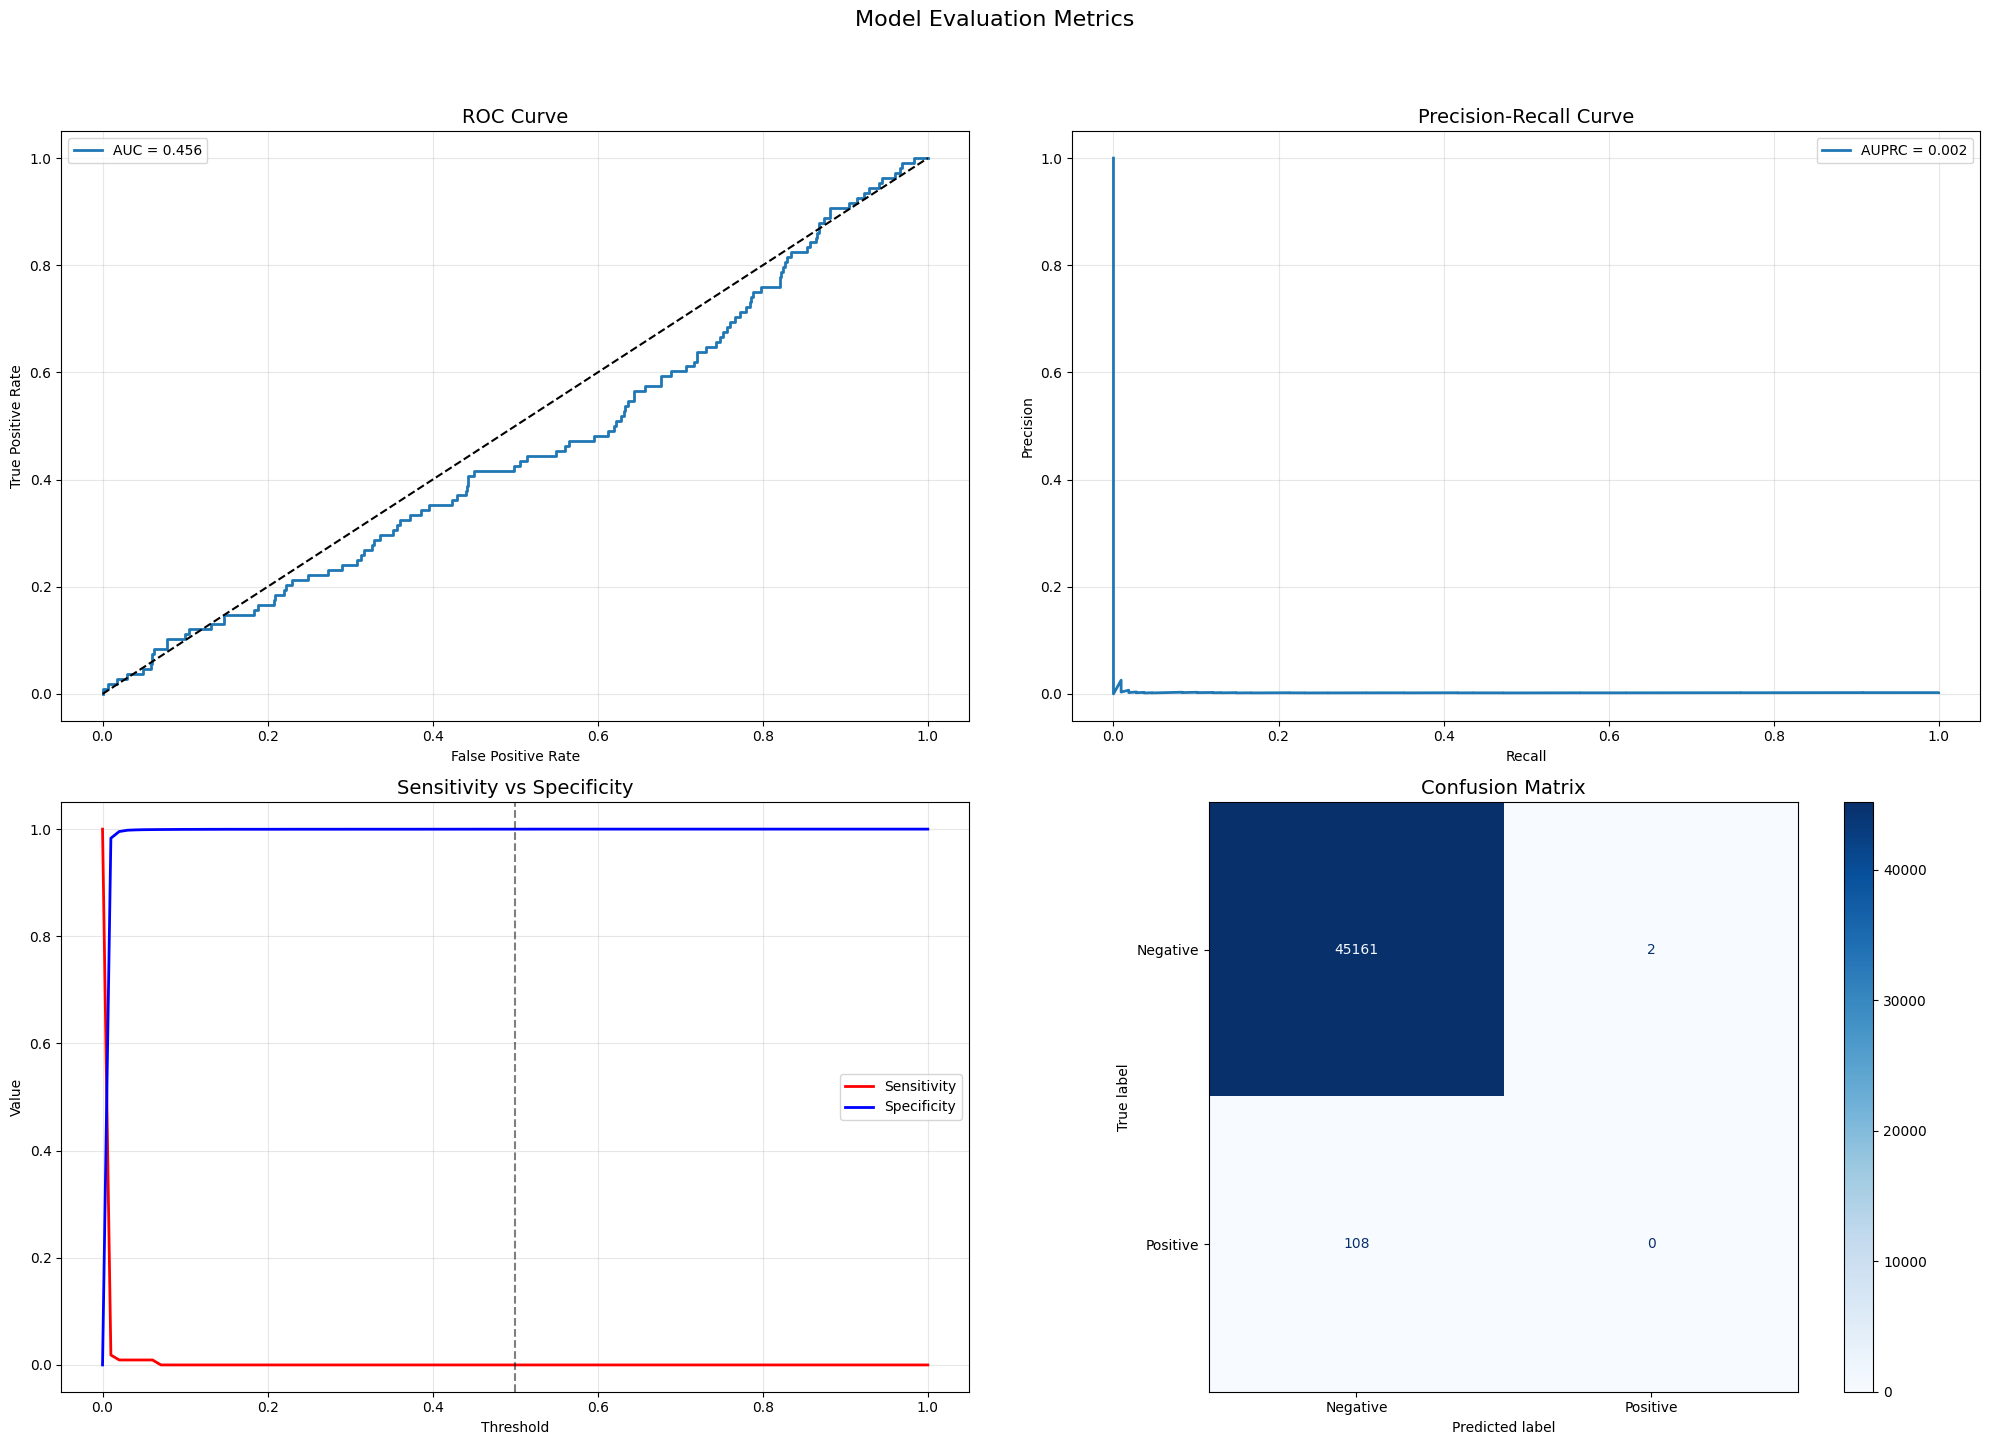

In [0]:
def extract_positive_prob(probability_vector):
    return float(probability_vector[1])

extract_positive_prob_udf = udf(extract_positive_prob, DoubleType())

# Use the UDF to create the 'probability_pos' column and convert the Spark DataFrame to Pandas
pandas_df = test_predictions.select(
    col("label").cast("double").alias("label"),
    col("prediction").cast("double").alias("prediction"),
    extract_positive_prob_udf(col("probability")).alias("probability_pos")
).toPandas()


# Get data for calculations
y_true = pandas_df["label"].values
y_pred = pandas_df["prediction"].values
y_prob = pandas_df["probability_pos"].values
## Plotting against the train data 

threshold = 0.5

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
ax1 = plt.subplot(2, 2, 1)
ax1.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')  # auc should be calculated from your evaluator
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_prob)
ax2 = plt.subplot(2, 2, 2)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'AUPRC = {auprc:.3f}')  # auprc from evaluator
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Sensitivity vs Specificity at different thresholds
thresholds_range = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

for t in thresholds_range:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity.append(sens)
    specificity.append(spec)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(thresholds_range, sensitivity, 'r-', linewidth=2, label='Sensitivity')
ax3.plot(thresholds_range, specificity, 'b-', linewidth=2, label='Specificity')
ax3.axvline(x=threshold, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Value')
ax3.set_title('Sensitivity vs Specificity', fontsize=14)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ax4 = plt.subplot(2, 2, 4)
# ConfusionMatrixDisplay will plot on the provided axis
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(ax=ax4, cmap='Blues', values_format='d')
ax4.set_title('Confusion Matrix', fontsize=14)

plt.suptitle("Model Evaluation Metrics", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

**Observation**: 
- The model appears to classify nearly everything as negative and completely misses the positive class (0 true positives).
- This model yields a very low true‐positive rate and a PR‐AUC of only 0.002, indicating poor performance on the minority class.
- Although precision and recall look high for the negative class, the overall ROC curve has an AUC of 0.456, which is close to random performance.
- The confusion matrix confirms a severe imbalance where 108 out of 108 positives are misclassified, suggesting the model is not recognizing positives at all.